## Лабораторная работа №5 по курсу "Нейроинформатика" на тему "Сети с обратными связями"

*Целью работы* является исследование свойств сети Элмана, алгоритмов обучения, а также применение сетей в задачах распознавания статических и динамических образов.


**Задание:** Использовать сеть Элмана для распознавания динамических образов. Проверить качество распознавания.

### Вариант 10
Выполнил студент Шавандрин Фёдор  
Группа М8О-408Б-19

In [1]:
# импортируем библиотеки
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Layer
from keras import backend as back

import matplotlib.pyplot as plt

Зададим основной сигнал $p_1$ и сигнал $p_2$, подлежащий распознаванию. Каждому значению основного сигнала соответствует −1 целевого выхода, каждому значению сигнала $p_2$ соответствует 1 целевого выхода.


In [2]:
def p1(k):
    return np.sin(4 * np.pi * k)

def p2(k):
    return np.sin(-3 * k ** 2 + 5 * k + 10) + 0.8

k1_begin = 0
k1_end = 1

k2_begin = 0.46
k2_end = 3.01

# шаг 
h = 0.025

# длительности основного сигнала
# R = (r1, r2, r3)
R = (0, 2, 2)

Согласно условию работы, входное множество формируется следующим образом: сначала идут $r_1$ повторений сигнала $p_1$, затем один сигнал $p_2$, далее идут $r_2$ повторений сигнала $p_1$, затем один сигнал $p_2$ и, наконец, $r_3$ повторений сигнала $p_1$, затем один сигнал $p_2$. Все входные сигналы и целевые выходы (-1 и 1) объединим в соответствующие массивы.

In [6]:
k1_vals = np.arange(k1_begin, k1_end + h, h)
k2_vals = np.arange(k2_begin, k2_end + h, h)

p1_vals = p1(k1_vals)
p2_vals = p2(k2_vals)

P = np.concatenate((
    np.tile(p1_vals, R[0]),
    p2_vals,
    np.tile(p1_vals, R[1]),
    p2_vals,
    np.tile(p1_vals, R[-1]),
    p2_vals,
))

p1_len = len(p1_vals)
p2_len = len(p2_vals)

T = np.concatenate((
    np.ones(R[0] * p1_len),
    -np.ones(p2_len),
    np.ones(R[1] * p1_len),
    -np.ones(p2_len),
    np.ones(R[-1] * p1_len),
    -np.ones(p2_len),
))

X = np.arange(len(P)) * h

Посмотрим на входящий и целевой сигналы.

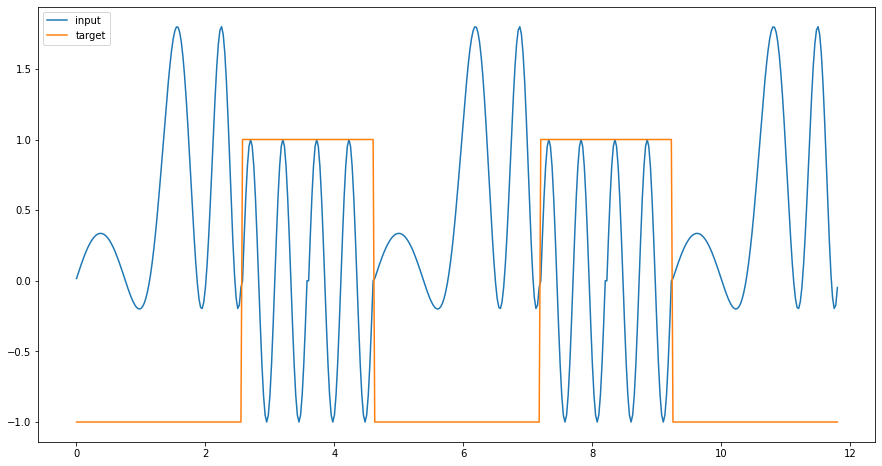

In [25]:
plt.figure(figsize=(15, 8))
plt.plot(X, P, label='input')
plt.plot(X, T, label='target')
plt.legend()
plt.show()

### Генерация датасета

В качестве фичей будем использовать нескольно подряд идущих входных сигналов, в качестве таргетов - тип сигнала для каждого последовательного входного сигнала

In [10]:
delay = 3

P_train = np.array([np.hstack([P[i:i+delay]]) for i in range(len(P) - delay)])
T_train = np.array([np.hstack([T[i:i+delay]]) for i in range(len(T) - delay)])

In [11]:
P_train.shape, T_train.shape

((470, 3), (470, 3))

### Реализация слоя сети Элмана

In [15]:
class Elman(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        self.prev = tf.Variable(tf.zeros((1, output_dim)))
        super(Elman, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w1 = self.add_weight(
            name='w1',
            shape=(input_shape[1], self.output_dim),
            initializer='uniform',
            trainable=True,
        )

        self.w2 = self.add_weight(
            name='w2',
            shape=(self.output_dim, self.output_dim),
            initializer='uniform',
            trainable=True,
        )

        self.b = self.add_weight(
            name='b',
            shape=(self.output_dim, ),
            initializer='uniform',
            trainable=True,
        )

        super(Elman, self).build(input_shape)

    def call(self, inputs):
        out = inputs @ self.w1 + self.b
        out += self.prev @ self.w2
        out = tf.keras.activations.tanh(out)
        self.prev.assign(out)
        return out

### Обучение модели
В качестве лосса буду использовать MSE, алгоритм обучения - Adam

In [53]:
model = keras.Sequential([
    Elman(output_dim=8),
    keras.layers.Dense(delay),
])

In [54]:
model.compile(
    loss='mse',
    optimizer='Adam',
)

In [58]:
train_info = model.fit(
    P_train,
    T_train,
    batch_size=1,
    epochs=700,
    verbose=0,
)

### График лосса

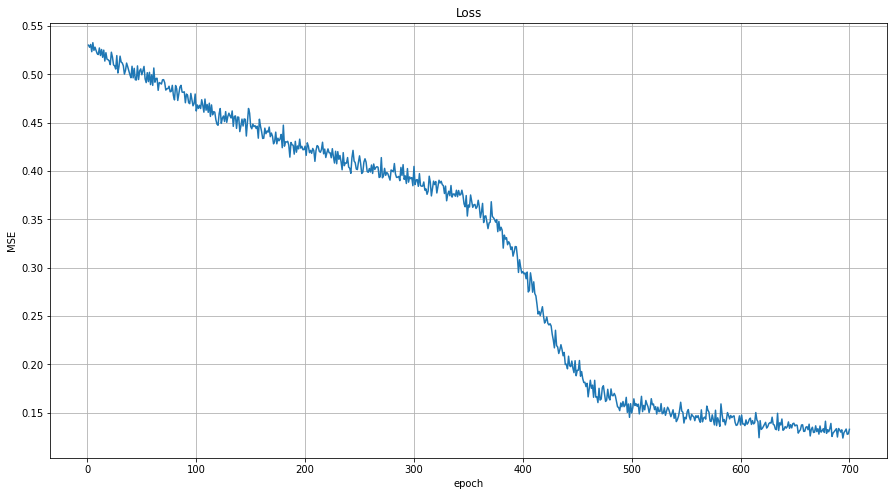

In [59]:
plt.figure(figsize=(15, 8))

loss_history = train_info.history['loss']
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.plot(range(1, len(loss_history) + 1), loss_history)
plt.title('Loss')
plt.grid()

plt.show()

### Результат работы модели

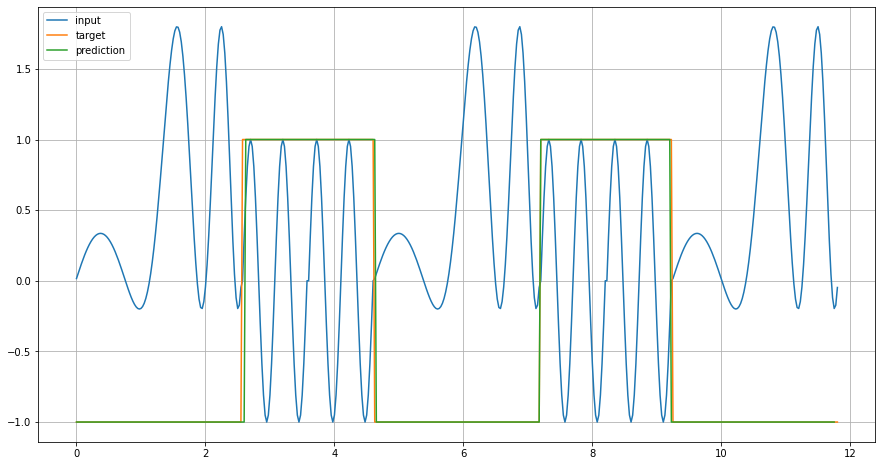

In [60]:
plt.figure(figsize=(15, 8))

predictions = np.hstack([
    np.sign(model.predict(
        np.expand_dims(P_train[i], axis=0),
    ))
    for i in range(0, len(P_train), delay)
])[0]

plt.plot(X, P, label='input')
plt.plot(X, T, label='target')
plt.plot(X[:-delay + 1], predictions, label='prediction')

plt.grid()
plt.legend()
plt.show()

### Выводы

В ходе данной лабораторной работы познакомился с одним из примеров нейронных сетей с обратными связями - сетью Элмана. 

Использовал данную сеть для решения задачи определения типа сигнала. По результатам работы модели можно сделать вывод, что сеть достаточно хорошо угадывает таргет, однако заметные небольшие погрешности на границах сигналов.